In [1]:
# imports
import os
from typing import Tuple
import scipy.stats as stats
import torch as t
from torch.nn.functional import conv2d, pad
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import imageio
from scipy import ndimage
from tqdm import tqdm
import pandas as pd

In [2]:
# set device
device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")

In [3]:
# get_active_pixel_idx(batch: t.Tensor) -> Returns list of indices where pixels > 0
def get_active_pixel_idx(batch:t.Tensor) -> t.Tensor:
    return batch.nonzero().T

In [4]:
def take_step(batch:t.Tensor, v_cur, p_vchg, facing_left, p_reverse, dim=-1) -> t.Tensor: 
    # find active pixels
    act_pixel_idx = get_active_pixel_idx(batch)
    batch_size,height,width = batch.shape

    # determine pixels next to active pixel (uses periodic torus)
    left_px = act_pixel_idx.clone()
    right_px = act_pixel_idx.clone()
    left_px[dim] -= 1
    right_px[dim] += 1
    left_px[dim][left_px[dim] < 0] = width -1
    right_px[dim][right_px[dim] == width] = 0

    # update the direction of the cells
    logits = t.hstack([t.log(1-p_reverse).unsqueeze(-1), t.log(p_reverse).unsqueeze(-1)])
    logit_tile = logits.repeat((batch_size,1))
    outcome = t.nn.functional.gumbel_softmax(logit_tile, tau=1, hard=True)
    facing_left = facing_left * outcome[:,0] + (1 - facing_left) * outcome[:,1]
    
    # update the velocity of the cells
    logits_vchg = t.hstack([t.log(1-p_vchg), t.log(p_vchg)])
    logit_tile_vchg = logits_vchg.repeat((batch_size,1))
    v_chg = t.nn.functional.gumbel_softmax(logit_tile_vchg, tau=1, hard=True)
    v_cur = v_cur * v_chg[:,0] + (1-v_cur) * v_chg[:,1]

    batch[act_pixel_idx[0], act_pixel_idx[1], act_pixel_idx[2]] -= 1 * v_cur

    batch[left_px[0], left_px[1], left_px[2]] += facing_left * v_cur
    batch[right_px[0], right_px[1], right_px[2]] += (1-facing_left) * v_cur
    return batch, facing_left, v_cur

In [5]:
def init_batch(n:int, dim:int, init_v_rand=False, device=t.device("cpu")):
    batch = t.zeros((n,dim,dim), device=device)
    batch[:,dim//2,dim//2] = 1
    facing_left_x = t.bernoulli(t.tensor(0.5, device=device).repeat(n))
    facing_left_y = t.bernoulli(t.tensor(0.5, device=device).repeat(n))
    v_x = t.ones((n), device=device)
    v_y = t.ones((n), device=device)
    return batch, facing_left_x, facing_left_y, v_x, v_y

In [6]:
# create_dist_matrix(batch:t.Tensor) -> Create distance matrix with same width/height as reference batch
def create_dist_matrix(batch:t.Tensor, device=t.device("cpu")) -> t.Tensor:   
    dist_matrix:np.ndarray = ndimage.distance_transform_edt(1-batch[0].cpu(), return_indices=False)
    dist_matrix = dist_matrix**2
    dist_matrix_t = t.from_numpy(dist_matrix).to(device)
    return dist_matrix_t

In [7]:
# calc_stats(batch:t.Tensor, dist_matrix:t.Tensor) -> Returns (sq_distances, avg_sq_distance, std_distance)
def calc_stats(batch:t.Tensor, dist_matrix:t.Tensor) -> Tuple[t.Tensor, t.Tensor, t.Tensor]:
    distances = (dist_matrix[batch.nonzero(as_tuple=True)[1:]] * batch[batch.nonzero(as_tuple=True)])
    return distances, t.mean(distances), t.std(distances)

In [40]:
p_reverse = t.tensor(0.9,device=device)
p_reverse.requires_grad_()
p_vchg = t.tensor(0.9,device=device)
p_vchg.requires_grad_()
ref_grid = t.zeros((1,512,512))
ref_grid[0,256,256] = 1
dist_mtx = create_dist_matrix(ref_grid,device=device)
target_msd = 100

p_rev_vals = []
p_vchg_vals = []
grads_rev = []
grads_vchg = []
msds = []
losses = []

t.autograd.set_detect_anomaly(False)

In [44]:
for i in tqdm(range(20)):
    test_batch, dir_x, dir_y, v_x, v_y = init_batch(100,512,device=device)
    #print(dir_x.shape)
    for j in range(100):
        test_batch, dir_x, v_x = take_step(test_batch, v_x, p_vchg, dir_x, p_reverse, dim=-1)
        test_batch, dir_y, v_y = take_step(test_batch, v_y, p_vchg, dir_y, p_reverse, dim=-2)
    distances, msd, std = calc_stats(test_batch,dist_mtx)
    loss = (msd - target_msd)**2
    grad_rev, grad_vchg = t.autograd.grad(loss,(p_reverse, p_vchg))
    p_reverse = t.clamp(p_reverse - 1e-8 * grad_rev, min=0, max=1)
    p_vchg = t.clamp(p_vchg - 1e-8 * grad_vchg, min=0, max=1)

    print(p_reverse,p_vchg)
    p_rev_vals.append(p_reverse.detach().clone().cpu().numpy())
    p_vchg_vals.append(p_vchg.detach().clone().cpu().numpy())
    grads_rev.append(grad_rev.detach().clone().cpu().numpy())
    grads_vchg.append(grad_vchg.detach().clone().cpu().numpy())
    msds.append(msd.detach().clone().cpu().numpy())
    losses.append(loss.detach().clone().cpu().numpy())


  5%|▌         | 1/20 [00:01<00:36,  1.90s/it]

tensor(0.8050, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7506, device='cuda:0', grad_fn=<ClampBackward1>)


 10%|█         | 2/20 [00:03<00:31,  1.76s/it]

tensor(0.8058, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7512, device='cuda:0', grad_fn=<ClampBackward1>)


 15%|█▌        | 3/20 [00:05<00:29,  1.71s/it]

tensor(0.8066, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7523, device='cuda:0', grad_fn=<ClampBackward1>)


 20%|██        | 4/20 [00:06<00:26,  1.69s/it]

tensor(0.8051, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7504, device='cuda:0', grad_fn=<ClampBackward1>)


 25%|██▌       | 5/20 [00:08<00:25,  1.73s/it]

tensor(0.8045, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7494, device='cuda:0', grad_fn=<ClampBackward1>)


 30%|███       | 6/20 [00:10<00:23,  1.70s/it]

tensor(0.8032, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7480, device='cuda:0', grad_fn=<ClampBackward1>)


 35%|███▌      | 7/20 [00:11<00:21,  1.68s/it]

tensor(0.8023, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7470, device='cuda:0', grad_fn=<ClampBackward1>)


 40%|████      | 8/20 [00:13<00:20,  1.67s/it]

tensor(0.8022, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7467, device='cuda:0', grad_fn=<ClampBackward1>)


 45%|████▌     | 9/20 [00:15<00:18,  1.67s/it]

tensor(0.8019, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7464, device='cuda:0', grad_fn=<ClampBackward1>)


 50%|█████     | 10/20 [00:16<00:16,  1.66s/it]

tensor(0.8018, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7462, device='cuda:0', grad_fn=<ClampBackward1>)


 55%|█████▌    | 11/20 [00:18<00:14,  1.66s/it]

tensor(0.8010, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7454, device='cuda:0', grad_fn=<ClampBackward1>)


 60%|██████    | 12/20 [00:20<00:13,  1.66s/it]

tensor(0.8020, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7465, device='cuda:0', grad_fn=<ClampBackward1>)


 65%|██████▌   | 13/20 [00:21<00:11,  1.65s/it]

tensor(0.8017, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7461, device='cuda:0', grad_fn=<ClampBackward1>)


 70%|███████   | 14/20 [00:23<00:09,  1.65s/it]

tensor(0.8012, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7455, device='cuda:0', grad_fn=<ClampBackward1>)


 75%|███████▌  | 15/20 [00:25<00:08,  1.65s/it]

tensor(0.7990, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7430, device='cuda:0', grad_fn=<ClampBackward1>)


 80%|████████  | 16/20 [00:26<00:06,  1.65s/it]

tensor(0.7998, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7436, device='cuda:0', grad_fn=<ClampBackward1>)


 85%|████████▌ | 17/20 [00:28<00:04,  1.65s/it]

tensor(0.7990, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7425, device='cuda:0', grad_fn=<ClampBackward1>)


 90%|█████████ | 18/20 [00:30<00:03,  1.65s/it]

tensor(0.7993, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7428, device='cuda:0', grad_fn=<ClampBackward1>)


 95%|█████████▌| 19/20 [00:31<00:01,  1.65s/it]

tensor(0.7985, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7421, device='cuda:0', grad_fn=<ClampBackward1>)


100%|██████████| 20/20 [00:33<00:00,  1.67s/it]

tensor(0.7984, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7420, device='cuda:0', grad_fn=<ClampBackward1>)


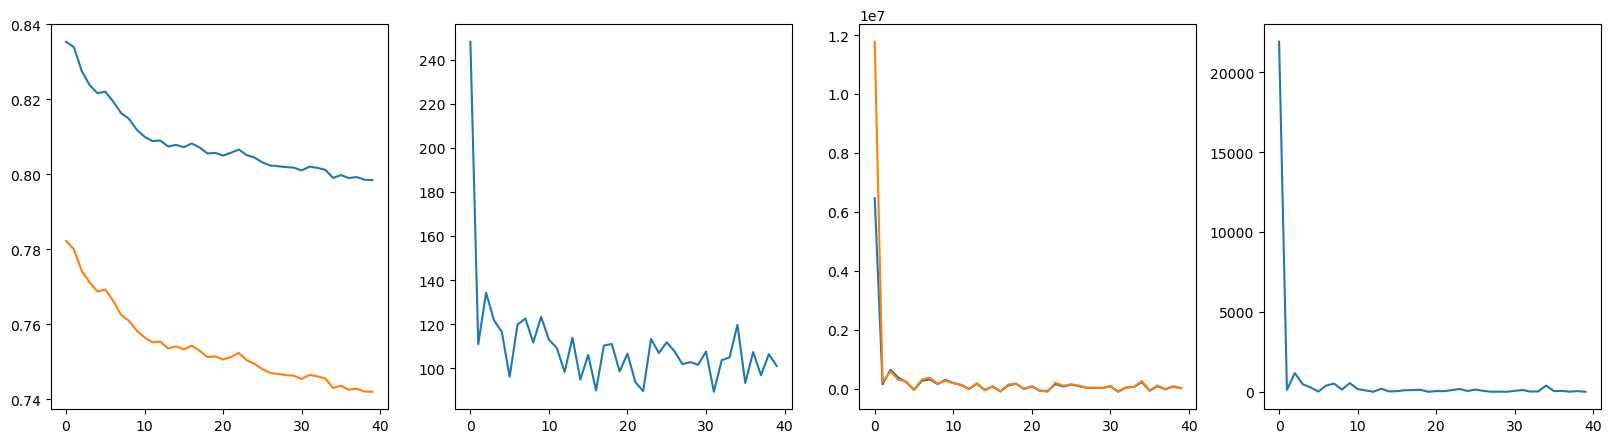

In [45]:
fig, axs = plt.subplots(1,4, figsize=(20,5))
axs[0].plot(p_rev_vals)
axs[0].plot(p_vchg_vals)
axs[1].plot(msds)
axs[2].plot(grads_rev)
axs[2].plot(grads_vchg)
axs[3].plot(losses)